In [1]:
from datetime import date
from nsepy import get_history
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
symbol="MRF"
start=date(2012,1,1)
end=date(2023,3,1)

In [3]:
df=get_history(symbol=symbol,start=start,end=end)

In [4]:
df.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2012-01-02,MRF,EQ,6979.20,6980.0,7040.00,6871.1,7006.0,6943.05,6935.99,4210,2.920052e+12,1563,872,0.2071
2012-01-03,MRF,EQ,6943.05,6950.0,7130.00,6950.0,7070.0,7069.05,7074.42,12459,8.814023e+12,2447,7479,0.6003
2012-01-04,MRF,EQ,7069.05,7090.0,7100.00,6981.0,6982.0,7011.50,7041.24,3368,2.371490e+12,1171,939,0.2788
2012-01-05,MRF,EQ,7011.50,7021.0,7087.55,6915.0,6934.0,6956.85,7033.22,15716,1.105341e+13,1520,6980,0.4441
2012-01-06,MRF,EQ,6956.85,6930.0,6999.00,6891.0,6974.0,6957.75,6943.01,2814,1.953763e+12,1447,481,0.1709


In [5]:
df.reset_index(inplace=True)

In [6]:
#converting object column to datetime 
df["Date"]=pd.to_datetime(df["Date"])

In [7]:
#dropping columns symbol and series
df.drop(["Symbol","Series"],axis=1,inplace=True)
df.head()

,Date,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2012-01-02,6979.20,6980.0,7040.00,6871.1,7006.0,6943.05,6935.99,4210,2.920052e+12,1563,872,0.2071
1,2012-01-03,6943.05,6950.0,7130.00,6950.0,7070.0,7069.05,7074.42,12459,8.814023e+12,2447,7479,0.6003
2,2012-01-04,7069.05,7090.0,7100.00,6981.0,6982.0,7011.50,7041.24,3368,2.371490e+12,1171,939,0.2788
3,2012-01-05,7011.50,7021.0,7087.55,6915.0,6934.0,6956.85,7033.22,15716,1.105341e+13,1520,6980,0.4441
4,2012-01-06,6956.85,6930.0,6999.00,6891.0,6974.0,6957.75,6943.01,2814,1.953763e+12,1447,481,0.1709


In [8]:
df1=df.reset_index()['Close']

In [9]:
df1

0        6943.05
1        7069.05
2        7011.50
3        6956.85
4        6957.75
          ...   
2764    86730.85
2765    86800.70
2766    85143.10
2767    85256.60
2768    86068.60
Name: Close, Length: 2769, dtype: float64

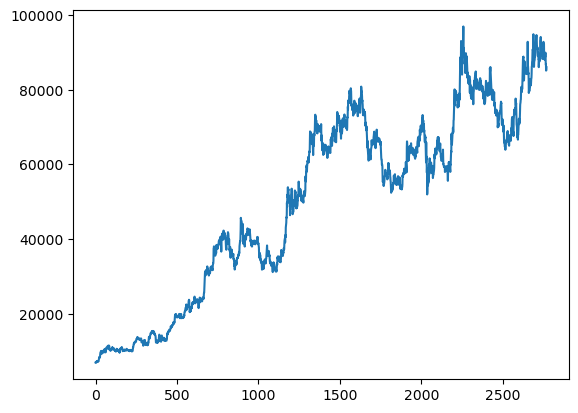

In [10]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [11]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

In [12]:
import numpy as np

In [13]:
df1

0        6943.05
1        7069.05
2        7011.50
3        6956.85
4        6957.75
          ...   
2764    86730.85
2765    86800.70
2766    85143.10
2767    85256.60
2768    86068.60
Name: Close, Length: 2769, dtype: float64

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [15]:
print(df1)

[[0.00000000e+00]
 [1.39952105e-03]
 [7.60295366e-04]
 ...
 [8.68592193e-01]
 [8.69852873e-01]
 [8.78872008e-01]]


In [16]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.70)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [17]:
training_size,test_size

(1938, 831)

In [18]:
train_data

array([[0.        ],
       [0.00139952],
       [0.0007603 ],
       ...,
       [0.64675755],
       [0.64367139],
       [0.65234009]])

In [19]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [20]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 150
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [21]:
print(X_train.shape), print(y_train.shape)

(1787, 150)
(1787,)


(None, None)

In [22]:
print(X_test.shape), print(ytest.shape)

(680, 150)
(680,)


(None, None)

In [23]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [51]:
X_train

array([[[0.00000000e+00],
        [1.39952105e-03],
        [7.60295366e-04],
        ...,
        [3.12626346e-02],
        [2.94254855e-02],
        [3.10321579e-02]],

       [[1.39952105e-03],
        [7.60295366e-04],
        [1.53280877e-04],
        ...,
        [2.94254855e-02],
        [3.10321579e-02],
        [3.18080035e-02]],

       [[7.60295366e-04],
        [1.53280877e-04],
        [1.63277456e-04],
        ...,
        [3.10321579e-02],
        [3.18080035e-02],
        [3.79331296e-02]],

       ...,

       [[5.60603149e-01],
        [5.57791334e-01],
        [5.62767964e-01],
        ...,
        [6.37318007e-01],
        [6.27975648e-01],
        [6.25814166e-01]],

       [[5.57791334e-01],
        [5.62767964e-01],
        [5.60815854e-01],
        ...,
        [6.27975648e-01],
        [6.25814166e-01],
        [6.26244574e-01]],

       [[5.62767964e-01],
        [5.60815854e-01],
        [5.60932481e-01],
        ...,
        [6.25814166e-01],
        [6.2624

In [24]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout

In [25]:
model=Sequential()
model.add(LSTM(80,return_sequences=True,input_shape=(150,1)))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(30))
model.add(Dropout(0.2))
model.add(Dense(1))

adam = Adam(learning_rate= 0.01)
model.compile(loss='mean_squared_error',optimizer= adam)

In [26]:
X_train.shape[1]

150

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150, 80)           26240     
                                                                 
 dropout (Dropout)           (None, 150, 80)           0         
                                                                 
 lstm_1 (LSTM)               (None, 150, 50)           26200     
                                                                 
 dropout_1 (Dropout)         (None, 150, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 30)                9720      
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [28]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=80,batch_size=70,verbose=1)

Epoch 1/80
26/26 [==============================] - 21s 474ms/step - loss: 0.0319 - val_loss: 0.0015
Epoch 2/80
26/26 [==============================] - 10s 382ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 3/80
26/26 [==============================] - 10s 394ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 4/80
26/26 [==============================] - 11s 406ms/step - loss: 0.0019 - val_loss: 0.0035
Epoch 5/80
26/26 [==============================] - 11s 415ms/step - loss: 0.0024 - val_loss: 0.0050
Epoch 6/80
26/26 [==============================] - 11s 407ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 7/80
26/26 [==============================] - 11s 413ms/step - loss: 0.0018 - val_loss: 0.0065
Epoch 8/80
26/26 [==============================] - 10s 403ms/step - loss: 0.0017 - val_loss: 0.0043
Epoch 9/80
26/26 [==============================] - 10s 394ms/step - loss: 0.0021 - val_loss: 0.0046
Epoch 10/80
26/26 [==============================] - 10s 392ms/step - loss: 0.0018 - val_lo

In [29]:
import tensorflow as tf

In [30]:
tf.__version__

'2.11.0'

In [31]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

22/22 [==============================] - 2s 68ms/step


In [32]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [54]:
y=y_train.reshape(-1, 1)

In [55]:
y_p=scaler.inverse_transform(y)

In [70]:
y_p

array([[ 9806.75],
       [10358.2 ],
       [10659.85],
       ...,
       [63324.35],
       [65171.15],
       [64893.3 ]])

In [58]:
train_predict

array([[ 9730.357],
       [ 9737.253],
       [ 9858.372],
       ...,
       [64491.586],
       [64338.63 ],
       [64961.95 ]], dtype=float32)

In [56]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_p,train_predict))

1150.399356663198

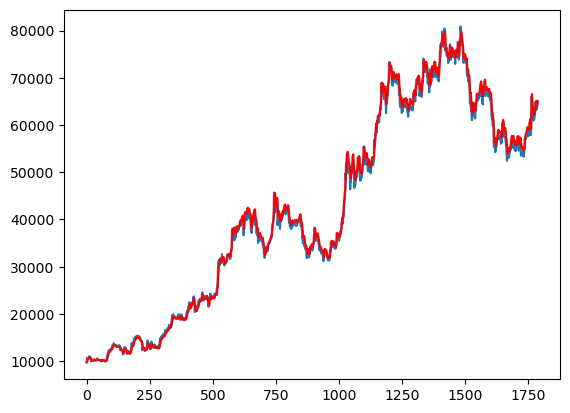

In [72]:
plt.plot(y_p)
plt.plot(train_predict,color="red")

In [52]:
y_train

array([0.031808  , 0.03793313, 0.04128365, ..., 0.62624457, 0.64675755,
       0.64367139])

In [60]:
Y=ytest.reshape(-1, 1)

In [61]:
y_test=scaler.inverse_transform(Y)

In [62]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

1723.256370568998

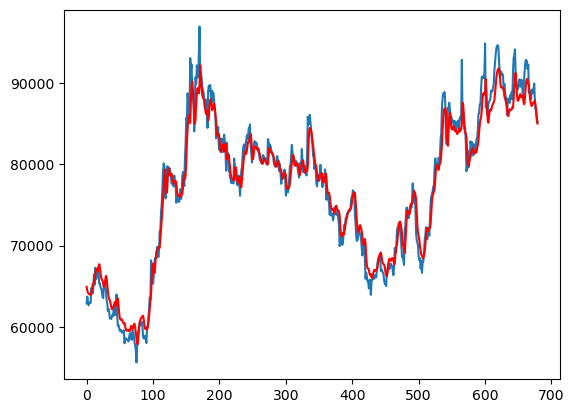

In [71]:
plt.plot(y_test)
plt.plot(test_predict,color="red")

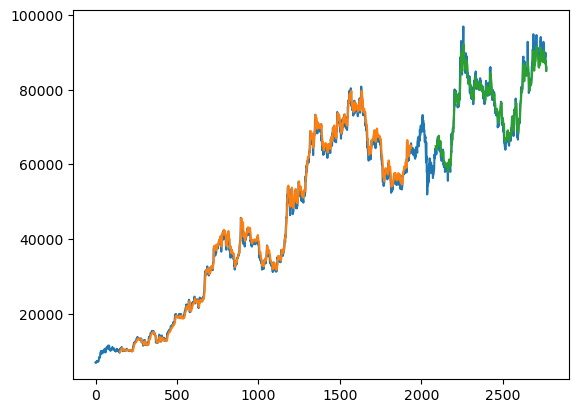

In [36]:
### Plotting 
# shift train predictions for plotting
look_back=150
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [37]:
len(test_data)

831

In [38]:
x_input=test_data[681:].reshape(1,-1)
x_input.shape

(1, 150)

In [39]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [40]:
temp_input

[0.8131345050804835,
 0.8210734548621138,
 0.8453046068678718,
 0.8538755625852484,
 0.8886658787881481,
 0.9022478973862277,
 0.9085324133518751,
 0.9082308498869276,
 0.9102707073579263,
 0.897186851610782,
 0.8499707877748504,
 0.8392422371010808,
 0.8462415084615487,
 0.8889002430279415,
 0.8875912465511803,
 0.8957878859234839,
 0.8872835740657641,
 0.8650950563584906,
 0.8769487775294675,
 0.8699406203210456,
 0.8719454897657245,
 0.8700267019731025,
 0.8605455022059116,
 0.8710563496048018,
 0.8685883053355073,
 0.8598596258169425,
 0.8587172389893236,
 0.8698650906134344,
 0.8684833412565477,
 0.8714056745025035,
 0.858206302731954,
 0.875980775467951,
 0.8731256414471491,
 0.8789064409068895,
 0.9544000497607483,
 0.8793635067110367,
 0.8820287057318162,
 0.8743446687133736,
 0.8590238007437453,
 0.8615768159341025,
 0.8403357517649515,
 0.8020949497283152,
 0.8095896071122327,
 0.8160946031802448,
 0.8072676239686862,
 0.8298437867929641,
 0.8183999253588772,
 0.8428493360050

In [41]:
# prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=150
i=0
while(i<30):
    
    if(len(temp_input)>150):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.86517227]
151
1 day input [0.82107345 0.84530461 0.85387556 0.88866588 0.9022479  0.90853241
 0.90823085 0.91027071 0.89718685 0.84997079 0.83924224 0.84624151
 0.88890024 0.88759125 0.89578789 0.88728357 0.86509506 0.87694878
 0.86994062 0.87194549 0.8700267  0.8605455  0.87105635 0.86858831
 0.85985963 0.85871724 0.86986509 0.86848334 0.87140567 0.8582063
 0.87598078 0.87312564 0.87890644 0.95440005 0.87936351 0.88202871
 0.87434467 0.8590238  0.86157682 0.84033575 0.80209495 0.80958961
 0.8160946  0.80726762 0.82984379 0.81839993 0.84284934 0.83856969
 0.84222955 0.83703633 0.82347374 0.8390312  0.83492871 0.82646272
 0.83665701 0.84576723 0.8464481  0.85780366 0.88060697 0.88134838
 0.8930255  0.89324764 0.9155228  0.93105859 0.93176058 0.9294347
 0.92984956 0.93640288 0.97696622 0.88941118 0.8944228  0.87984723
 0.8801077  0.89559573 0.89683697 0.89910786 0.90135431 0.91251161
 0.91094548 0.91113375 0.91592655 0.92147965 0.93957568 0.9510312
 0.9620541  0.97058396 0.9731242  0.

In [42]:
day_new=np.arange(1,151)
day_pred=np.arange(151,181)

In [63]:
day_new

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150])

In [43]:
import matplotlib.pyplot as plt

In [44]:
len(df1)

2769

In [64]:
scaler.inverse_transform(lst_output)

array([[84835.20133224],
       [84658.83939936],
       [84232.17392178],
       [83760.90950842],
       [83362.28270721],
       [83046.62892308],
       [82777.80643632],
       [82524.44949317],
       [82276.15829365],
       [82036.36724024],
       [81810.9631134 ],
       [81602.34999487],
       [81409.30974503],
       [81229.29339328],
       [81060.1651706 ],
       [80900.77133241],
       [80750.55915456],
       [80609.21202807],
       [80476.28992014],
       [80351.27767038],
       [80233.64938593],
       [80122.86844139],
       [80018.50553646],
       [79920.16356835],
       [79827.44543428],
       [79740.03989153],
       [79657.60349984],
       [79579.84648151],
       [79506.46832633],
       [79437.21145411]])

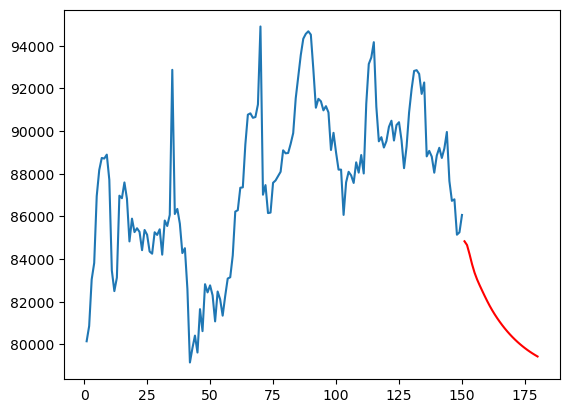

In [65]:
plt.plot(day_new,scaler.inverse_transform(df1[2619:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output),color="red")

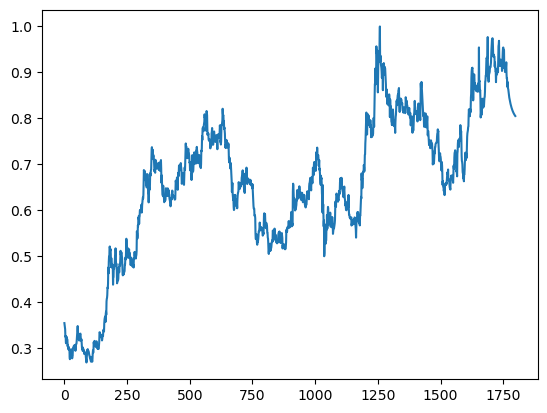

In [46]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1000:])

In [47]:
df3=scaler.inverse_transform(df3).tolist()

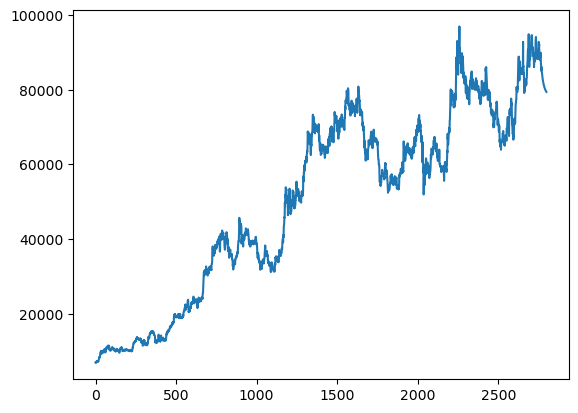

In [48]:
plt.plot(df3)

In [49]:
lst_output

[[0.865172266960144],
 [0.8632133603096008],
 [0.8584742546081543],
 [0.8532397747039795],
 [0.8488121032714844],
 [0.8453060388565063],
 [0.8423201441764832],
 [0.8395060300827026],
 [0.8367481827735901],
 [0.8340847492218018],
 [0.8315811157226562],
 [0.8292639851570129],
 [0.8271198272705078],
 [0.8251203298568726],
 [0.8232417702674866],
 [0.8214713335037231],
 [0.8198028802871704],
 [0.8182328939437866],
 [0.8167564868927002],
 [0.8153679370880127],
 [0.8140614032745361],
 [0.812830924987793],
 [0.8116717338562012],
 [0.8105794191360474],
 [0.8095495700836182],
 [0.8085787296295166],
 [0.807663083076477],
 [0.8067994117736816],
 [0.805984377861023],
 [0.8052151203155518]]

In [50]:
fore=scaler.inverse_transform(lst_output)
fore

array([[84835.20133224],
       [84658.83939936],
       [84232.17392178],
       [83760.90950842],
       [83362.28270721],
       [83046.62892308],
       [82777.80643632],
       [82524.44949317],
       [82276.15829365],
       [82036.36724024],
       [81810.9631134 ],
       [81602.34999487],
       [81409.30974503],
       [81229.29339328],
       [81060.1651706 ],
       [80900.77133241],
       [80750.55915456],
       [80609.21202807],
       [80476.28992014],
       [80351.27767038],
       [80233.64938593],
       [80122.86844139],
       [80018.50553646],
       [79920.16356835],
       [79827.44543428],
       [79740.03989153],
       [79657.60349984],
       [79579.84648151],
       [79506.46832633],
       [79437.21145411]])

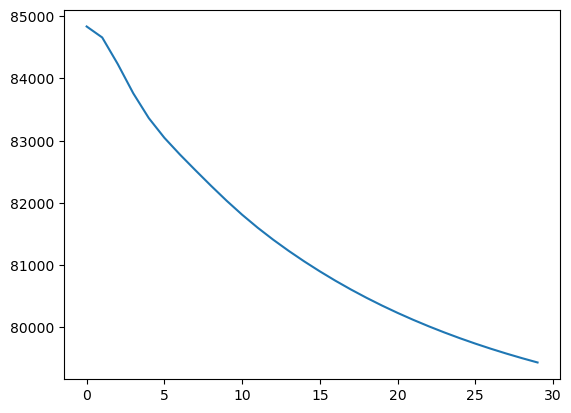

In [66]:
plt.plot(fore)